# DL_PJT <리뷰 데이터를 이용한 약물 추천 시스템>

1. 데이터 summary 및 Reference
<br></br>
2. EDA
    1) 데이터 선별
    2) feature간 상관관계 분석
    3) 리뷰(review), 약물(drugName), 증상(condition) 데이터 분석
    4) date(날짜) 분석
    5) 리뷰 데이터 심층분석 - gram 분석
<br></br>
3. 데이터 전처리
    1) 걸측치 제거
    2) 증상 데이터 전처리
    3) 리뷰 데이터 전처리
<br></br>
4. 모델링
    1) 딥러닝 모델 N-grams
    2) Dictionary Sentiment Analysis
<br></br>
5. 추천시스템
    1) 증상(condition)과 리뷰(review)를 활용한 추천 시스템

## 1. 데이터 summary 및 Reference

- 1. drugsComTrain_raw.csv & drugsComTest_raw.csv
        - 출처 : https://www.kaggle.com/datasets/jessicali9530/kuc-hackathon-winter-2018
        
                - drugName : 의약품 명칭
                - condition : 증상
                - review : 복용자들의 리뷰
                - rating : 복용자 점수
                - date : 리뷰가 등록된 날짜
                - usefulCount : 리뷰가 유용하다고 생각하는 사용자 수

- 2. inquirerbasic.csv
        - 출처 : https://www.kaggle.com/datasets/jylee4/dictionary
    
                - entry : 단어
                - Positiv : 긍정 반응
                - Negativ : 부정 반응

- 3. reference : https://www.kaggle.com/code/chocozzz/recommendation-medicines-by-using-a-review/notebook


### 1) 라이브러리 및 데이터 로드

In [1]:
# 라이브러리 로드
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import nltk
import string
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from matplotlib import rc
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

rc("font", family="Malgun Gothic")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#데이터 불러오기
df_train = pd.read_csv('drugsComTrain_raw.csv')
df_test = pd.read_csv('drugsComTest_raw.csv')

In [45]:
# 약물의 종류 갯수
len(df_train['drugName'].unique())

3436

In [46]:
# 증상 종류 수
len(df_train['condition'].unique())

885

In [3]:
# 모든 데이터 분석을 위해 test와 train 데이터를 병합
df_all = pd.concat([df_train,df_test])
df_all

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
...,...,...,...,...,...,...,...
53761,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10,13-Sep-14,43
53762,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9,8-Oct-16,11
53763,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8,15-Nov-10,7
53764,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1,28-Nov-11,20


In [48]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     215063 non-null  int64 
 1   drugName     215063 non-null  object
 2   condition    213869 non-null  object
 3   review       215063 non-null  object
 4   rating       215063 non-null  int64 
 5   date         215063 non-null  object
 6   usefulCount  215063 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 13.1+ MB


---

## 2. EDA

### 1) 데이터 선별

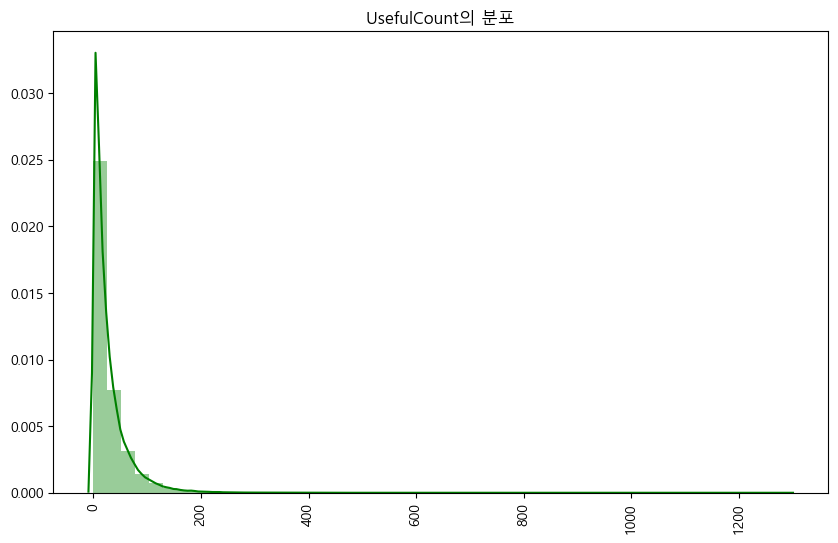

In [49]:
# UsefulCount의 분포분석
plt.figure(figsize=(10,6))
sns.distplot(df_all["usefulCount"].dropna(),color="green")
plt.xticks(rotation='vertical')
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title("UsefulCount의 분포")
plt.show()

In [50]:
df_all["usefulCount"].describe()

count    215063.000000
mean         28.001004
std          36.346069
min           0.000000
25%           6.000000
50%          16.000000
75%          36.000000
max        1291.000000
Name: usefulCount, dtype: float64

데이터에 대한 신뢰를 높이기 위해 리뷰에 대한 평가가 있는 데이터만 사용한다. 유용하다고 평가를 받은 리뷰(usefulCount != 0)만 추출하여 EDA를 진행

In [51]:
#데이터 선별
df_all = df_all[df_all['usefulCount'] != 0]
df_all

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
...,...,...,...,...,...,...,...
53761,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10,13-Sep-14,43
53762,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9,8-Oct-16,11
53763,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8,15-Nov-10,7
53764,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1,28-Nov-11,20


### 2) feature간 상관관계 분석

In [52]:
df_all['date'] = pd.to_datetime(df_all['date'])
df_all['year'] = df_all['date'].dt.year
df_all['month'] = df_all['date'].dt.month
df_all['day'] = df_all['date'].dt.day

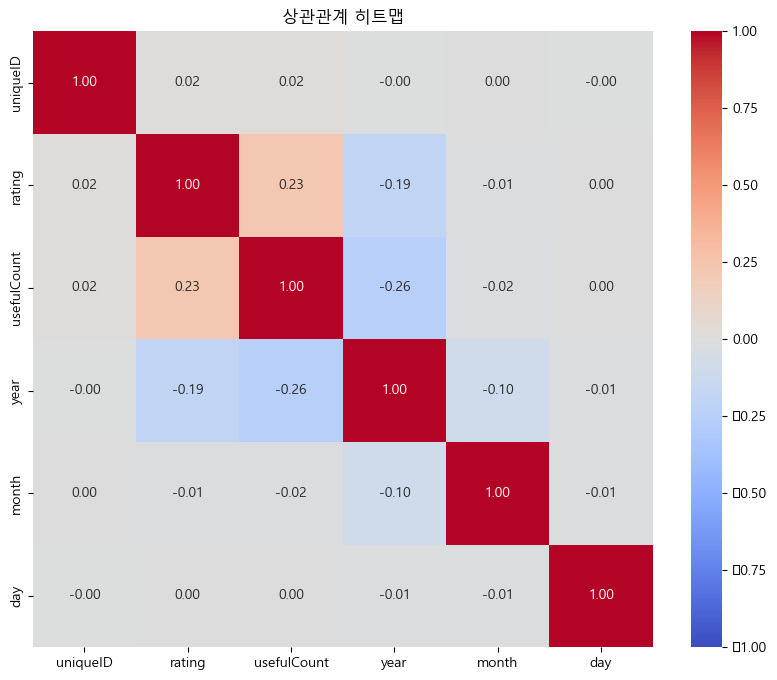

In [53]:
# 다중 상관관계 분석
corr = df_all.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f', vmin=-1, vmax=1)
plt.title('상관관계 히트맵')
plt.show()

   살펴 보아야 할 점
   - rating - usefulCount
   - rating - year
   - usefulCount - year
   

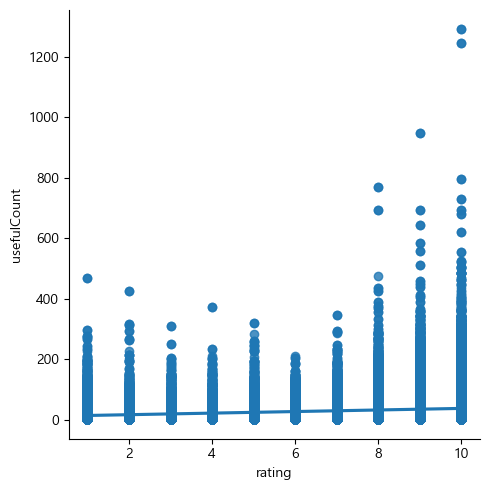

In [54]:
# rating - usefulCount
sns.lmplot(x='rating', y='usefulCount', data=df_all)

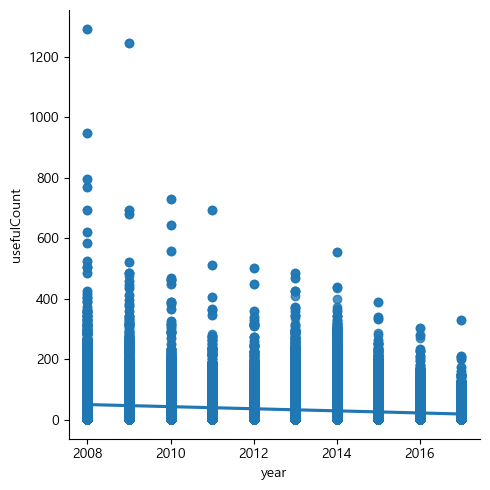

In [55]:
# usefulCount - year
sns.lmplot(x='year', y='usefulCount', data=df_all)

usefulCount에 이상치가 존재하고 이로 인해 상관관계에 대한 왜곡이 존재할 수 있을 수 있다고 생각하여 이상치를 제거 하고 다시 상관관계를 분석해보자

In [56]:
Q1 = df_all['usefulCount'].quantile(0.25)
Q3 = df_all['usefulCount'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df_all[(df_all['usefulCount'] >= lower_bound) & (df_all['usefulCount'] <= upper_bound)]

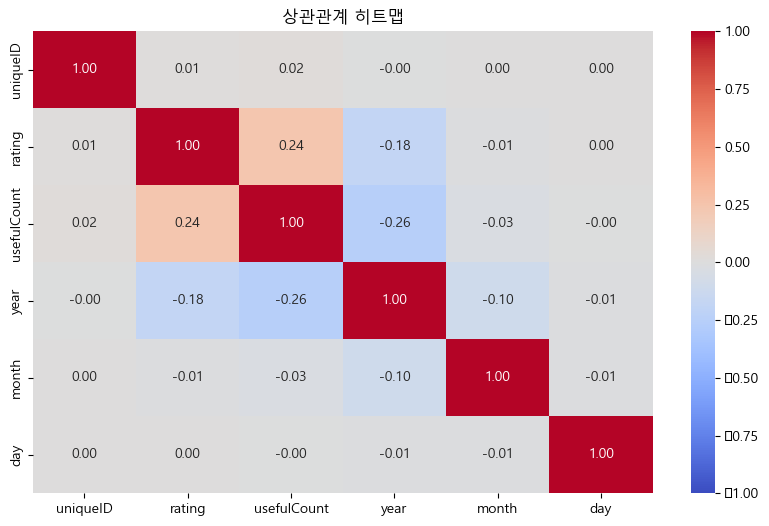

In [57]:
# 다중 상관관계 분석 (filtered)
corr = df_filtered.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f', vmin=-1, vmax=1)
plt.title('상관관계 히트맵')
plt.show()

### 3) 리뷰(review), 약물(drugName), 증상(condition) 데이터 분석

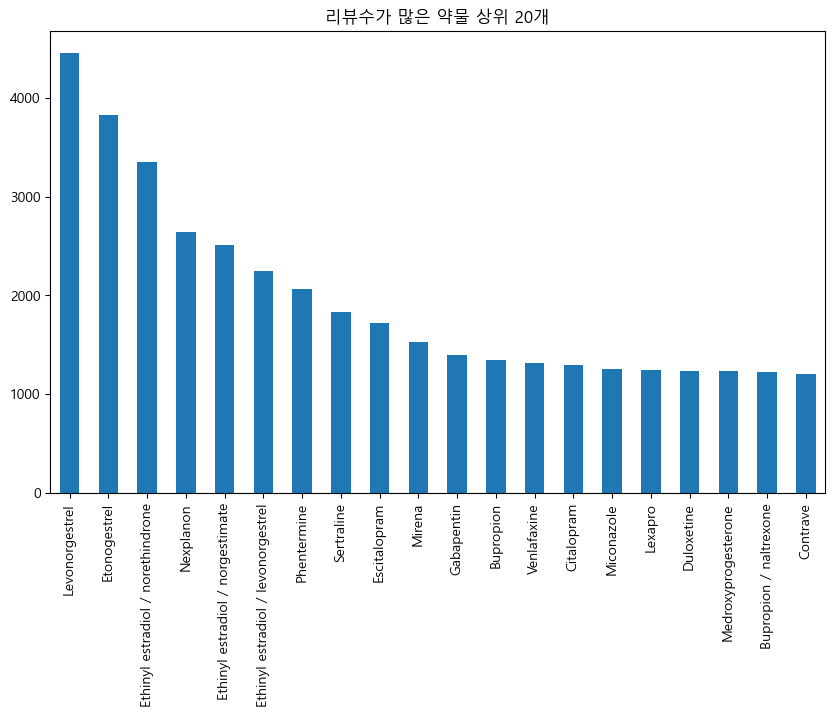

In [58]:
# 리뷰수가 많은 약물 상위 20개
plt.figure(figsize=(10,6))
df_all['drugName'].value_counts().nlargest(20).plot(kind='bar')
plt.title('리뷰수가 많은 약물 상위 20개')
plt.show()

- 가장 리뷰수가 많은 의약품은 levonorgestrel(응급 피임약) 이다.
- 그 다음으로 ETONOGESTREL(피임약), ethinyl estradiol(여성 호르몬제)가 리뷰수가 많았다.
- 가장 리뷰수가 적은 의약품은 contrave(다이어트약) 이다.

=> 증상별 의약품 수는 피임이 3번째로 많았고, 리뷰수는 가장 많다.

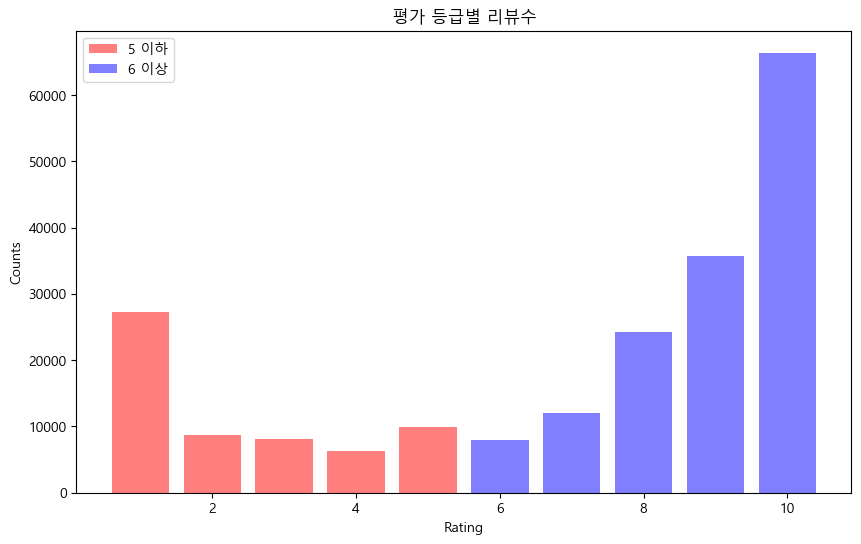

In [59]:
# 평가 등급별 리뷰수

rating_counts = df_all.groupby('rating').size().reset_index(name='counts')
rating_counts = rating_counts.sort_values(by='counts',ascending=False)
plt.figure(figsize=(10,6))
plt.bar(x=rating_counts['rating'][rating_counts['rating'] <= 5], height=rating_counts['counts'][rating_counts['rating'] <= 5], color='red', alpha=0.5, label='5 이하')
plt.bar(x=rating_counts['rating'][rating_counts['rating'] > 5], height=rating_counts['counts'][rating_counts['rating'] > 5], color='blue', alpha=0.5, label='6 이상')
plt.xlabel('Rating')
plt.ylabel('Counts')
plt.title('평가 등급별 리뷰수')
plt.legend()
plt.show()

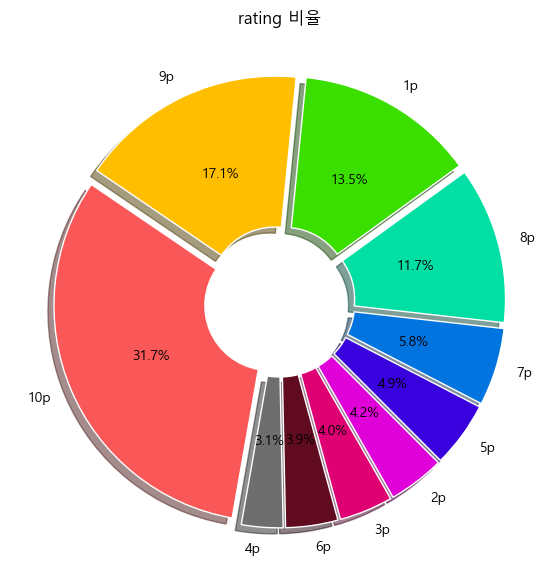

In [60]:
# 'rating'별 리뷰수 비율 파이차트
ratio = [31.6,17.0,13.4,11.7,5.8,4.9,4.2,4.0,3.9,3.1]
labels = ['10p','9p','1p','8p','7p','5p','2p','3p','6p','4p']

explode = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
colors = ['#FA5858', '#FFBF00', '#3ADF00', '#01DFA5', '#0174DF', '#3A01DF', '#DF01D7', '#DF0174', '#610B21', '#6E6E6E'] 
wedgeprops={'width': 0.7, 'edgecolor': 'w', 'linewidth': 1}

plt.figure(figsize=(7,7))
plt.pie(ratio, labels=labels, autopct='%.1f%%', startangle=260, counterclock=False, explode=explode, shadow=True, colors=colors, wedgeprops=wedgeprops)
plt.title('rating 비율')
plt.show()



- 의약품을 복용한 환자들은 대부분의 긍정적인 점수를 줬다.
- 반면에, 3번째로 높은 비율을 가진 rating은 1점이다.

=> 환자들은 자신이 복용한 의약품이 매우 긍정적이거나 매우 부정적일때 리뷰를 작성한다.

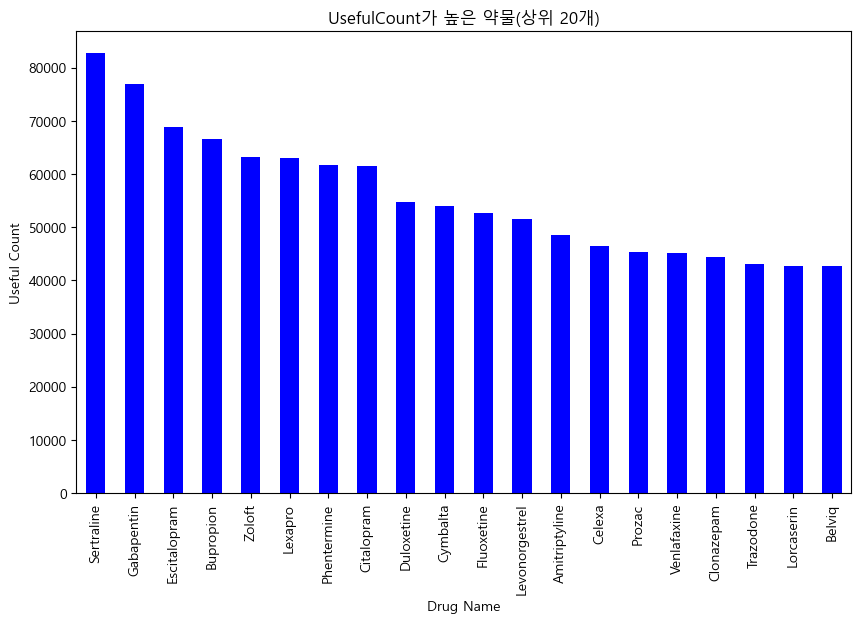

In [61]:
# UsefulCount가 높은 약물(상위 20개)

plt.figure(figsize=(10,6))
top_20_drugs = df_all.groupby('drugName')['usefulCount'].sum().sort_values(ascending=False).head(20)
top_20_drugs.plot(kind='bar', color='blue')
plt.xlabel('Drug Name')
plt.ylabel('Useful Count')
plt.title('UsefulCount가 높은 약물(상위 20개)')
plt.xticks(rotation=90)
plt.show()

### 4) date(날짜) 분석

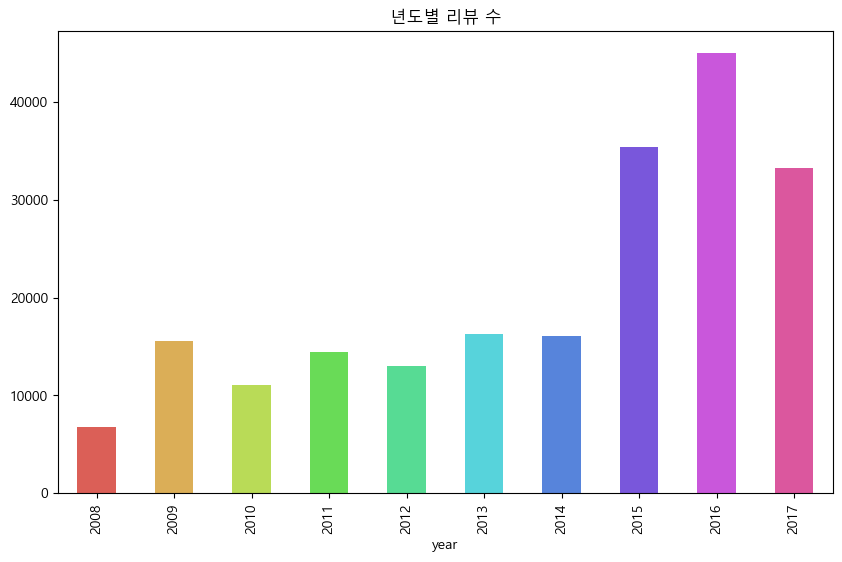

In [62]:
# 년도별 리뷰 수
df_all['date'] = pd.to_datetime(df_all['date'])
df_tmp = df_all.groupby('year').size()

plt.figure(figsize=(10,6))
colors = sns.color_palette('hls',len(df_tmp))
df_tmp.plot(kind="bar", color=colors)
plt.title('년도별 리뷰 수')
plt.show()


- 2014년 이후 리뷰의 양이 급증했다. 

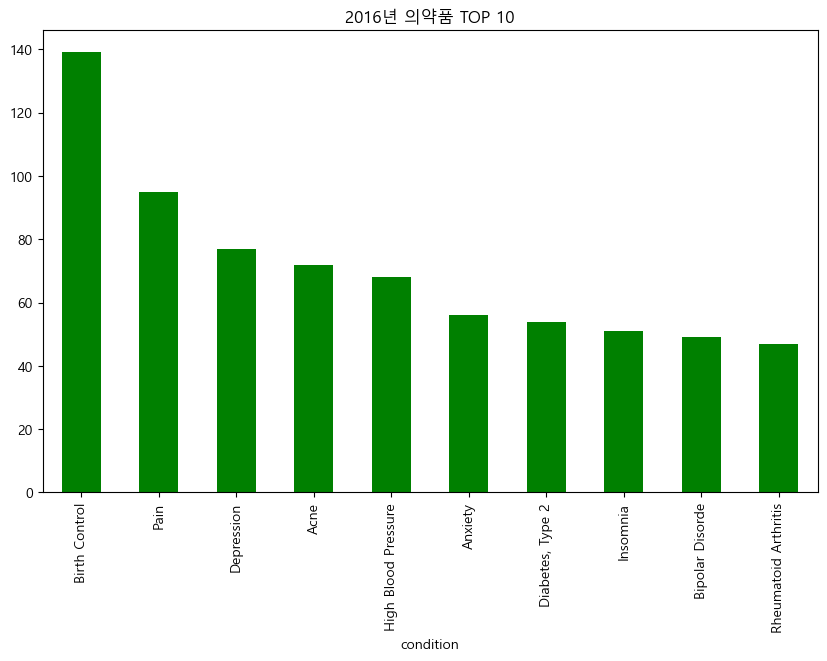

In [63]:
plt.figure(figsize=(10,6))
df_all_2016 = df_all[df_all['year'] == 2016]
df_all_2016_con = df_all_2016.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
df_all_2016_con[0:10].plot(kind="bar", color='green')
plt.title('2016년 의약품 TOP 10')
plt.show()

- 약 리뷰양이 가장 많았던 2016년에는 'Not Listed/Othe'가 아닌 Birth Control이 가장 많았다.

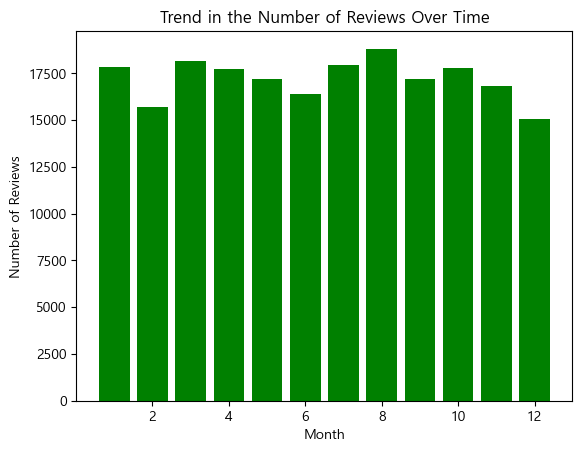

In [64]:
# 월별 리뷰수
reviews_per_month = df_all.groupby(df_all['date'].dt.month).size().reset_index(name='counts')
plt.bar(reviews_per_month['date'], reviews_per_month['counts'], color='green')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.title('Trend in the Number of Reviews Over Time')
plt.show()


월별 리뷰수는 유의미한 차이가 없다고 볼 수 있다.

Text(0.5, 1.0, '년도별 평균 평가등급')

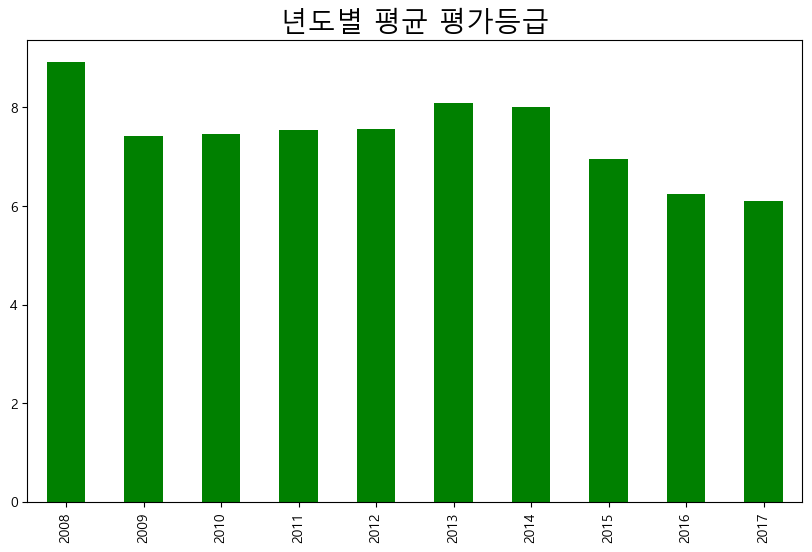

In [65]:
# 년도별 평균 평가등급
rating = df_all.groupby('year')['rating'].mean()
rating.plot(kind="bar", figsize = (10,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("년도별 평균 평가등급", fontsize = 20)

리뷰수가 증가한 2015년부터 평균 등급이 떨어지는 경향이 있다.

Text(0.5, 1.0, '월별 평균 평가등급')

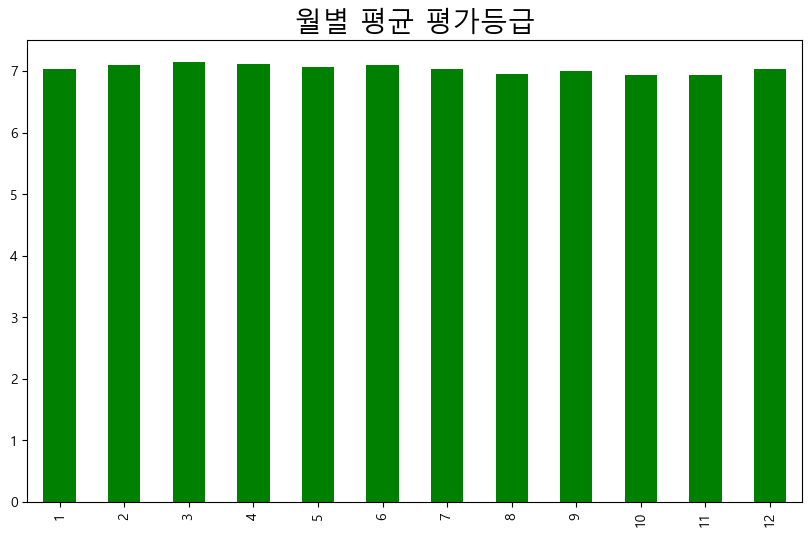

In [66]:
# 월별 평균 평가등급

rating = df_all.groupby('month')['rating'].mean()
rating.plot(kind="bar", figsize = (10,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("월별 평균 평가등급", fontsize = 20)

Text(0.5, 1.0, 'Mean rating in day')

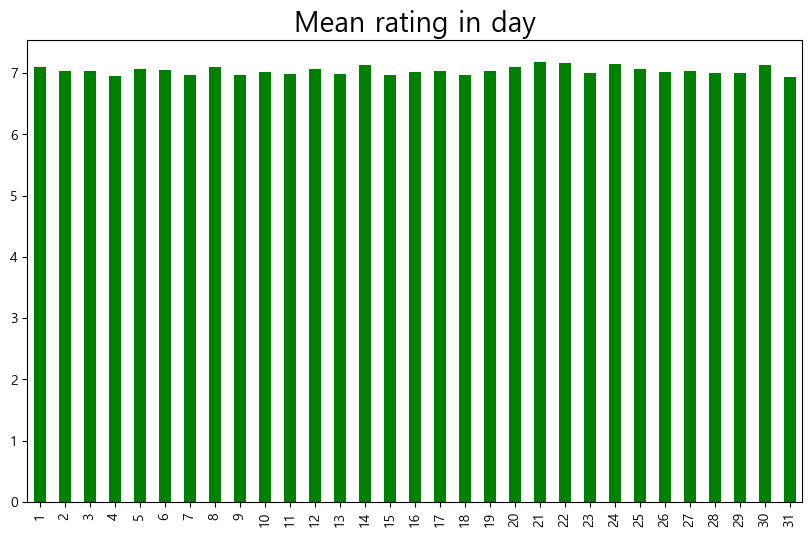

In [67]:
# 일별 평균 평가등급

rating = df_all.groupby('day')['rating'].mean()
rating.plot(kind="bar", figsize = (10,6), fontsize = 10,color="green")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Mean rating in day", fontsize = 20)

시간 요인(년, 월, 일)을 중심으로 리뷰 수와 평가등급에 대한 상관관계를 살펴본 결과 2015년 이후의 리뷰수와 평가등급의 요인에 대해서 살펴볼 필요가 있다. 하지만 그 외 월별, 일별 리뷰수와 평가 등급과는 관계성을 찾기 힘들다.

리뷰수가 증가하면서 평가등급이 낮아진 2015년 이후와 그 이전 기간에서 같은 약물에 대한 평가는 달라졌을까?

In [68]:
# 데이터 프레임에서 2008년부터 2017년까지 사용된 'drugName' 행 추출
start_year = 2008
end_year = 2017
df_filtered = df_all[(df_all['date'].dt.year >= start_year) & (df_all['date'].dt.year <= end_year)]

# 각 연도별로 사용된 약물 추출
drugNames = []
for year in range(start_year, end_year + 1):
    year_data = df_filtered[df_filtered['date'].dt.year == year]
    year_drugNames = year_data['drugName'].unique()
    drugNames.append(year_drugNames)
    
# 중복되지 않게 추출한 약물 리스트 합치기
drugNames_used_in_years = list(set(drugNames[0]).intersection(*drugNames[1:]))

len(drugNames_used_in_years)

540

In [69]:
#2015년 이전 이후 약물 평가 등급 차이
rating_before_2015 = df_all[df_all['date'].dt.year < 2015].groupby('drugName')['rating'].mean()
rating_before_2015 = rating_before_2015.loc[drugNames_used_in_years]
rating_after_2015 = df_all[df_all['date'].dt.year >= 2015].groupby('drugName')['rating'].mean()
rating_after_2015 = rating_after_2015.loc[drugNames_used_in_years]
df_compare = pd.concat([rating_before_2015, rating_after_2015], axis=1)
df_compare.columns = ['before_2015', 'after_2015']
df_compare

,before_2015,after_2015
drugName,,
Bactrim DS,6.582090,5.178218
Fluticasone,8.446429,5.988095
Pristiq,7.484155,6.301887
Sildenafil,8.690722,8.216418
Hydroxychloroquine,7.810811,6.430380
...,...,...
Diphenhydramine,7.316456,6.352941
Paxil,7.820669,6.601504
Dimenhydrinate,9.454545,9.352941


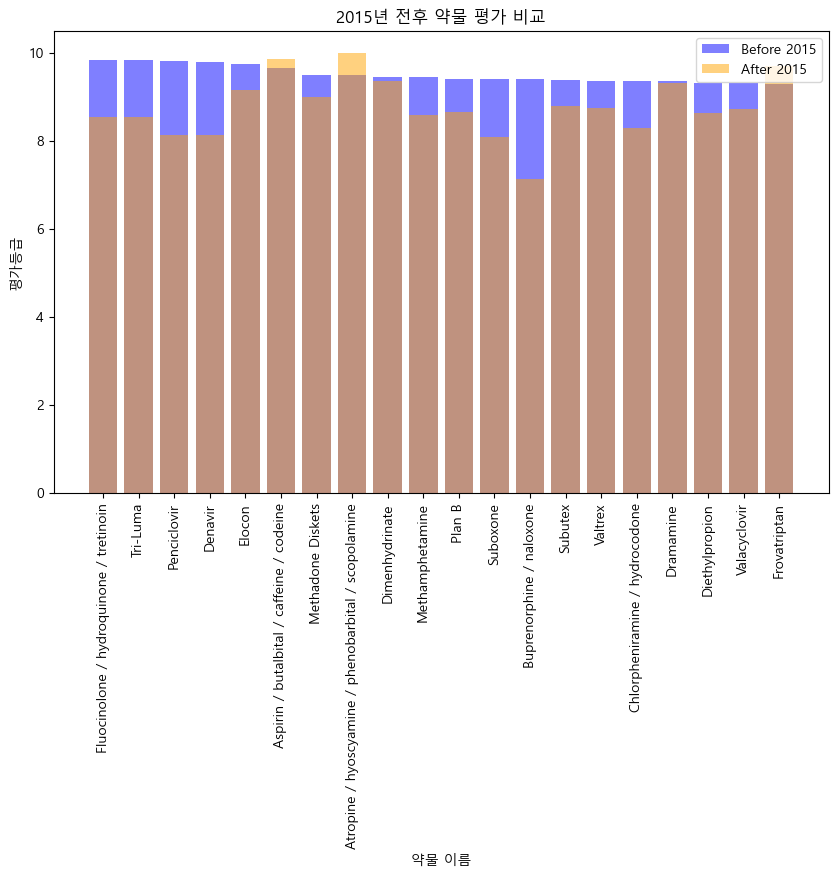

In [70]:
# 표 시각화
df_compare = df_compare.sort_values('before_2015', ascending=False)
df_top20 = df_compare.head(20)
plt.figure(figsize=(10, 6))
plt.bar(x=df_top20.index, height=df_top20['before_2015'], color='blue', alpha=0.5, label='Before 2015')
plt.bar(x=df_top20.index, height=df_top20['after_2015'], color='orange', alpha=0.5, label='After 2015')
plt.xticks(rotation=90)
plt.xlabel('약물 이름')
plt.ylabel('평가등급')
plt.title('2015년 전후 약물 평가 비교')
plt.legend()
plt.show()


전체적으로 평가가 2015년 이후로 낮아지는 경향을 볼 수 있다.(평가가 높아진 약물도 있다.) 하지만 좋다 나쁘다(좋다 :1-5, 나쁘다 : 6-10)의 변화에는 영향을 주지 못한다고 생각한다. 다만 평가 등급이 높은 리뷰에 대해 usefulCount가 높은 관계성에 대해서는 고려할 필요가 있다.

### 5) 리뷰 데이터 심층분석 - gram 분석

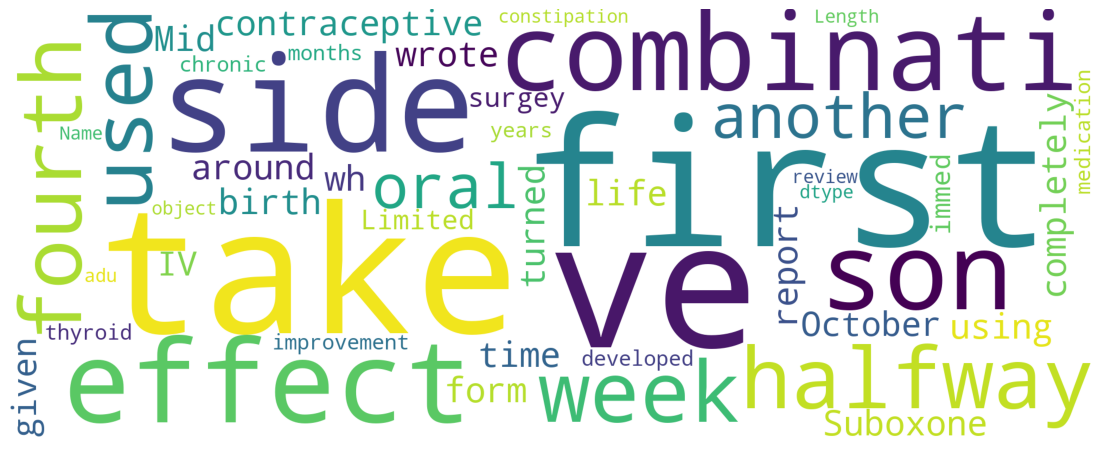

In [71]:
# 리뷰에 따른 wordcloud
from wordcloud import WordCloud, STOPWORDS

stop_words = set(STOPWORDS)
wordcloud = WordCloud(background_color = 'white', stopwords = stop_words, width = 2000, height = 800).generate(str(df_train['review']))

plt.figure(figsize=(14,14))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

- first : 처음 약을 복용한 환자들은 리뷰를 많이 쓰는 경향이 있다.
- combination : 여러가지 약을 함께 복용하는 환자가 많다.
- side + effect : 부작용에 대한 리뷰
- son : 자식에 대한 리뷰를 부모가 작성

선행 연구에서 Sentiment를 좋다, 나쁘다 두 Sentiment로 rating을 1-5, 6-10으로 나누어 리뷰를 분석했다. 이번에는 1-3, 4-7, 8-10 세 구간으로 나누어 분석하였다.

In [72]:
# rating 기준으로 데이터 나누기
from collections import defaultdict
df_all_bad = df_all[df_all["rating"]<4] # rating < 4 이만
df_all_so = df_all[(df_all["rating"]>=4) & (df_all["rating"] < 8)] # rating 4, 5, 6, 7
df_all_good = df_all[df_all["rating"]>7]

In [73]:
# 함수 설정 
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

1-gram 단위로 분석

rating 점수에 따라 
- 1~3점은 부정, 4~7점은 보통, 8~10점은 긍정으로 분류
- 1 ~ 4 grams을 통해 어떤 말뭉치가 가장 감성을 잘 분류하는지 판단한다.

1-gram 분석

In [74]:
# Good
freq_dict = defaultdict(int)
for sent in df_all_good["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# soso
freq_dict = defaultdict(int)
for sent in df_all_so["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# bad
freq_dict = defaultdict(int)
for sent in df_all_bad["review"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(50), 'red')

# 시각화
fig = tools.make_subplots(rows=1, cols=3, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of rating 1 to 3", 
                                          "Frequent words of rating 4 to 7",
                                          "Frequent words of rating 8 to 10"])
fig.append_trace(trace2, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace0, 1, 3)
fig['layout'].update(height=1000, width=1500, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots - 1")
py.iplot(fig, filename='word-plots')

세 구간에서 사용된 단어들이 유의미한 차이를 보이지 않았다.

2-gram 분석

In [75]:
# Good
freq_dict = defaultdict(int)
for sent in df_all_good["review"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# soso
freq_dict = defaultdict(int)
for sent in df_all_so["review"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# bad
freq_dict = defaultdict(int)
for sent in df_all_bad["review"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(50), 'red')

# 시각화
fig = tools.make_subplots(rows=1, cols=3, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of rating 1 to 3", 
                                          "Frequent words of rating 4 to 7",
                                          "Frequent words of rating 8 to 10"])
fig.append_trace(trace2, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace0, 1, 3)
fig['layout'].update(height=1000, width=1500, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots - 2")
py.iplot(fig, filename='word-plots')

3-gram 분석

In [76]:
# Good
freq_dict = defaultdict(int)
for sent in df_all_good["review"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# soso
freq_dict = defaultdict(int)
for sent in df_all_so["review"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# bad
freq_dict = defaultdict(int)
for sent in df_all_bad["review"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(50), 'red')

#시각화
fig = tools.make_subplots(rows=1, cols=3, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of rating 1 to 3", 
                                          "Frequent words of rating 4 to 7",
                                          "Frequent words of rating 8 to 10"])
fig.append_trace(trace2, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace0, 1, 3)
fig['layout'].update(height=1000, width=1500, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots - 3")
py.iplot(fig, filename='word-plots')

4-gram 분석

In [77]:
# Good
freq_dict = defaultdict(int)
for sent in df_all_good["review"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# soso
freq_dict = defaultdict(int)
for sent in df_all_so["review"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# bad
freq_dict = defaultdict(int)
for sent in df_all_bad["review"]:
    for word in generate_ngrams(sent,4):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(50), 'red')

#시각화
fig = tools.make_subplots(rows=1, cols=3, vertical_spacing=0.2, 
                          subplot_titles=["Frequent words of rating 1 to 3", 
                                          "Frequent words of rating 4 to 7",
                                          "Frequent words of rating 8 to 10"])
fig.append_trace(trace2, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace0, 1, 3)
fig['layout'].update(height=1000, width=2000, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots - 4")
py.iplot(fig, filename='word-plots')



이제 긍정, 중립, 부정에서 차이를 보이고 있다.

---

## 3. 데이터 전처리

### 1) 결측치 제거

Text(0.5, 1.0, 'Total Missing Value ')

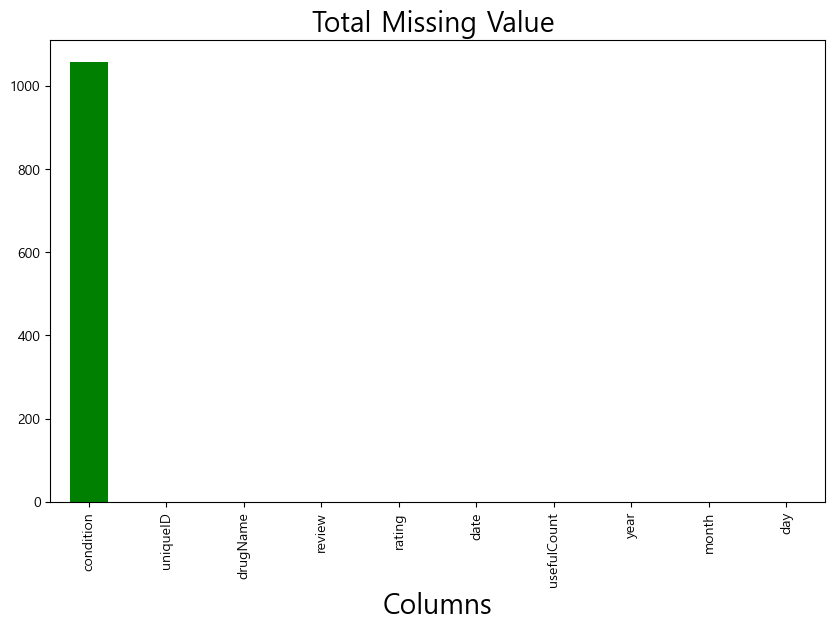

In [78]:
percent = (df_all.isnull().sum()).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (10,6), fontsize = 10, color='green')
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value ", fontsize = 20)

In [79]:
df_all = df_all.dropna(axis=0)

Text(0.5, 1.0, 'Total Missing Value ')

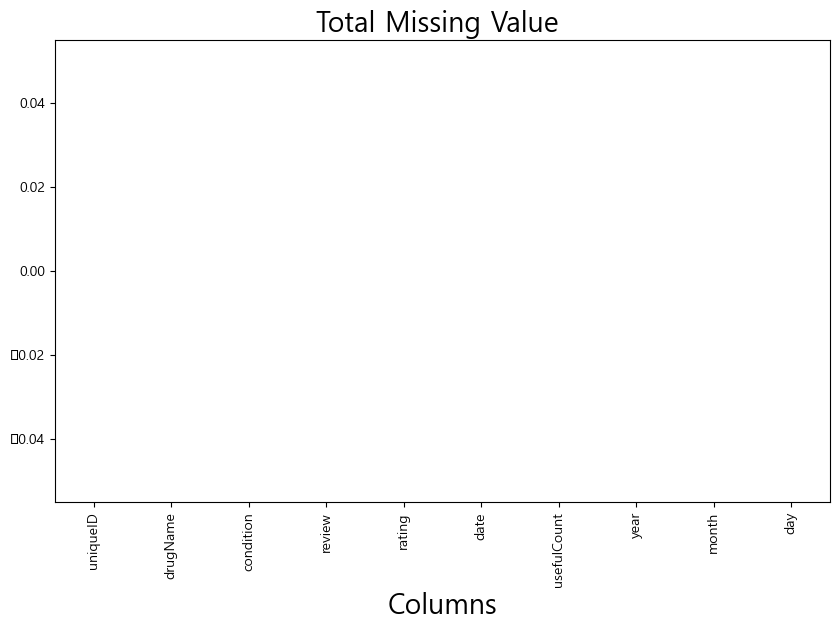

In [80]:
percent = (df_all.isnull().sum()).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (10,6), fontsize = 10, color='green')
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value ", fontsize = 20)

### 2) condition 전처리

In [81]:
# Thanks : https://www.kaggle.com/code/chocozzz/recommendation-medicines-by-using-a-review/notebook
# <span> 태그 삭제
all_list = set(df_all.index)
span_list = []
for i,j in enumerate(df_all['condition']):
    if '</span>' in j:
        span_list.append(i)

In [82]:
new_idx = all_list.difference(set(span_list))
df_all = df_all.iloc[list(new_idx)].reset_index()
del df_all['index']

약물 추천이 목표이기 때문에, 증상에 대해 처방할 약품이 하나인 경우는 목표에 맞지 않기 때문에 제거한다.

In [83]:
df_condition = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
df_condition = pd.DataFrame(df_condition).reset_index()
df_condition.tail(20)

,condition,drugName
766,Secondary Cutaneous Bacterial Infections,1
767,Cogan's Syndrome,1
768,Autoimmune Hemolytic Anemia,1
769,Hypopituitarism,1
770,Eyelash Hypotrichosis,1
771,Short Stature,1
772,Short Stature for Age,1
773,Asystole,1
774,Oppositional Defiant Disorde,1
775,"Skin Disinfection, Preoperative",1


In [84]:
# 1개의 증상에 대한 처방 약물 종류가 1개인 경우의 약물이름 추출
df_condition_1 = df_condition[df_condition['drugName']==1].reset_index()
df_condition_1['condition'][0:10]

0                        Hemangioma
1    Intermittent Explosive Disorde
2          Giant Cell Tumor of Bone
3              Gestational Diabetes
4              Tuberculosis, Active
5                        Angioedema
6                  Nephrocalcinosis
7                 Urinary Retention
8                         Toothache
9       Gastrointestinal Hemorrhage
Name: condition, dtype: object

In [85]:
#해당 증상 제거
all_list = set(df_all.index)
condition_list = []
for i,j in enumerate(df_all['condition']):
    for c in list(df_condition_1['condition']):
        if j == c:
            condition_list.append(i)
            
new_idx = all_list.difference(set(condition_list))
df_all = df_all.iloc[list(new_idx)].reset_index()
del df_all['index']

### 3) review 전처리

감정 분석에 중요한 부분이 되는 단어들을 stopword에서 제거

In [86]:
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [87]:
stops = set(stopwords.words('english'))

In [88]:
not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't","mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [89]:
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD


pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [90]:
from bs4 import BeautifulSoup
import re 
from nltk.corpus import stopwords 
from nltk.stem.snowball import SnowballStemmer

# 객체를 만들어 영어 어근 추출
stemmer = SnowballStemmer('english')

# 함수를 정의
def review_to_words(raw_review):
    
    # 1. HTML 태그 제거
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    
    # 2. 문자 이외 공백 치환, 문자열 소문자 변환
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    words = letters_only.lower().split()
    
    #stopwords 제거
    stops = set(stopwords.words('english'))
    meaningful_words = [w for w in words if not w in stops]
    
    #어근추출
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    
    return (' '.join(stemming_words))


In [91]:
%time df_all['review_clean'] = df_all['review'].apply(review_to_words)

CPU times: total: 2min 8s
Wall time: 2min 8s


---

## 4. 모델링

### 1) 딥러닝 모델 N-grams

In [92]:
# rating 값에 따라 sentiment 값을 설정하는 함수
def get_sentiment(rating):
    if rating < 4:
        return 0
    elif rating < 8:
        return 1
    else:
        return 2

# df_all['rating'] 값에 따라 df_all['sentiment'] 값을 설정합니다
df_all['sentiment'] = df_all['rating'].apply(get_sentiment)
df_all.head(30)

,uniqueID,drugName,condition,review,rating,date,usefulCount,year,month,day,review_clean,sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,2012,5,20,side effect take combin bystol mg fish oil,2
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,2010,4,27,son halfway fourth week intuniv becam concern ...,2
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,2009,12,14,use take anoth oral contracept pill cycl happi...,1
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10,2015,11,3,first time use form birth control glad went pa...,2
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37,2016,11,27,suboxon complet turn life around feel healthie...,2
5,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,2015-11-28,43,2015,11,28,nd day mg start work rock hard erect howev exp...,0
6,165907,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,2017-03-07,5,2017,3,7,pull cum bit took plan b hour later took pregn...,0
7,102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,2015-03-14,32,2015,3,14,abilifi chang life hope zoloft clonidin first ...,2
8,74811,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,2016-08-09,11,2016,8,9,noth problem keppera constant shake arm leg pi...,0
9,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,2016-12-08,1,2016,12,8,pill mani year doctor chang rx chateal effect ...,2


In [93]:
# 데이터 나누기
df_train, df_test = train_test_split(df_all, test_size=0.3, random_state=42)

In [94]:
# https://github.com/corazzon/KaggleStruggle/blob/master/word2vec-nlp-tutorial/tutorial-part-1.ipynb
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer(analyzer = 'word', 
                             tokenizer = None,
                             preprocessor = None, 
                             stop_words = None, 
                             min_df = 2,
                             ngram_range=(4, 4),
                             max_features = 20000
                            )
vectorizer

CountVectorizer(max_features=20000, min_df=2, ngram_range=(4, 4))

In [95]:
#https://stackoverflow.com/questions/28160335/plot-a-document-tfidf-2d-graph
pipeline = Pipeline([
    ('vect', vectorizer),
])

In [96]:
train_data_features = pipeline.fit_transform(df_train['review_clean'])
test_data_features = pipeline.fit_transform(df_test['review_clean'])

In [97]:
train_data_features = train_data_features.toarray()
test_data_features = test_data_features.toarray()

Epoch 1/20
6789/6789 [==============================] - 197s 29ms/step - loss: 0.9268 - accuracy: 0.6112
Epoch 2/20
6789/6789 [==============================] - 196s 29ms/step - loss: 0.8435 - accuracy: 0.6455
Epoch 3/20
6789/6789 [==============================] - 197s 29ms/step - loss: 0.7833 - accuracy: 0.6772
Epoch 4/20
6789/6789 [==============================] - 196s 29ms/step - loss: 0.7455 - accuracy: 0.6939
Epoch 5/20
6789/6789 [==============================] - 199s 29ms/step - loss: 0.7225 - accuracy: 0.7032
Epoch 6/20
6789/6789 [==============================] - 192s 28ms/step - loss: 0.7040 - accuracy: 0.7102
Epoch 7/20
6789/6789 [==============================] - 192s 28ms/step - loss: 0.6921 - accuracy: 0.7143
Epoch 8/20
6789/6789 [==============================] - 192s 28ms/step - loss: 0.6803 - accuracy: 0.7192
Epoch 9/20
6789/6789 [==============================] - 192s 28ms/step - loss: 0.6737 - accuracy: 0.7210
Epoch 10/20
6789/6789 [==============================] 

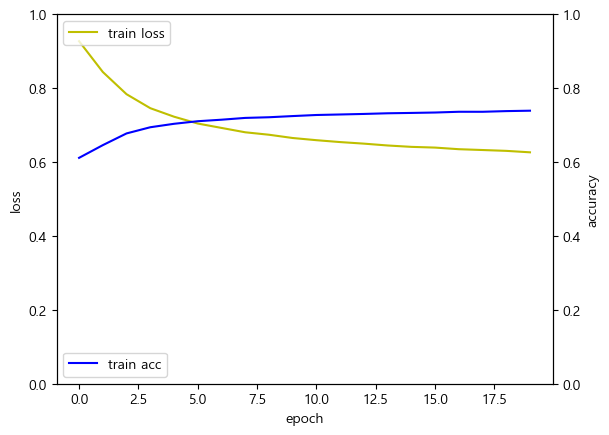

1455/1455 [==============================] - 6s 4ms/step - loss: 1.4416 - accuracy: 0.5399
loss_and_metrics : [1.4416252374649048, 0.5399355292320251]


In [98]:
# 0. Package
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
import random

# 1. Dataset
y_train = keras.utils.to_categorical(df_train['sentiment'], 3)
y_test = keras.utils.to_categorical(df_test['sentiment'], 3)
solution = y_test.copy()

# 2. Model Structure
model = keras.models.Sequential()

model.add(keras.layers.Dense(200, input_shape=(20000,)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(300))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))  # 뉴런 수를 3개로 변경, 활성화 함수를 'softmax'로 변경

# 3. Model compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # loss 함수를 'categorical_crossentropy'로 변경

# 4. Train model
hist = model.fit(train_data_features, y_train, epochs=20, batch_size=16)

# 5. Training process
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

# 6. Evaluation
loss_and_metrics = model.evaluate(test_data_features, y_test, batch_size=32)  # y_test를 one-hot 인코딩으로 변경한 후 평가
print('loss_and_metrics : ' + str(loss_and_metrics))


In [99]:
loss_and_metrics = model.evaluate(test_data_features, y_test, batch_size=16)  # y_test를 one-hot 인코딩으로 변경한 후 평가
print('loss_and_metrics : ' + str(loss_and_metrics))

2910/2910 [==============================] - 8s 3ms/step - loss: 1.4416 - accuracy: 0.5399
loss_and_metrics : [1.4416260719299316, 0.5399355292320251]


- 모든 predict_sentiment를 2라고 값을 주었을 경우 accuracy가 0.611 이라는 점에서 train_accuracy는 고려할 만한 모델이지만 모델의 성능강화가 필요하다고 판단하였다.
- inquirerbasic 사용전에는 오직 'review'컬럼만을 활용해서 긍정, 중립, 부정을 나눴지만 inquirerbasic을통해서 모든단어들에 긍정과 부정NaN(중립) 라벨링을 통해 정확도를 향상시킨다.

### 2) Dictionary Sentiment Analysis

In [100]:
word_table = pd.read_csv("inquirerbasic.csv")

In [101]:
# 부정과 긍정 데이터만 있기 때문에 부정, 긍정 둘다 아닌 데이터는 Neural이라고 가정. Value 부여
for index, row in word_table.iterrows():
    if pd.isnull(row['Positiv']) and pd.isnull(row['Negativ']):
        word_table.at[index, 'Neutral'] = 'Neutral'
    else:
        word_table.at[index, 'Neutral'] = np.nan
word_table.head()

,Entry,Source,Positiv,Negativ,Neutral
0,A,H4Lvd,NaN,NaN,Neutral
1,ABANDON,H4Lvd,NaN,Negativ,NaN
2,ABANDONMENT,H4,NaN,Negativ,NaN
3,ABATE,H4Lvd,NaN,Negativ,NaN
4,ABATEMENT,Lvd,NaN,NaN,Neutral


In [102]:
## make list of sentiment
#Positiv word list   
temp_Positiv = []
Positiv_word_list = []
for i in range(0,len(word_table.Positiv)):
    if word_table.iloc[i,2] == "Positiv":
        temp = word_table.iloc[i,0].lower()
        temp1 = re.sub('\d+', '', temp)
        temp2 = re.sub('#', '', temp1) 
        temp_Positiv.append(temp2)

Positiv_word_list = list(set(temp_Positiv))
len(temp_Positiv)
len(Positiv_word_list)  

#Negativ word list          
temp_Negativ = []
Negativ_word_list = []
for i in range(0,len(word_table.Negativ)):
    if word_table.iloc[i,3] == "Negativ":
        temp = word_table.iloc[i,0].lower()
        temp1 = re.sub('\d+', '', temp)
        temp2 = re.sub('#', '', temp1) 
        temp_Negativ.append(temp2)

Negativ_word_list = list(set(temp_Negativ))
len(temp_Negativ)
len(Negativ_word_list)  

#Neutral word list          
temp_Neutral = []
Neutral_word_list = []
for i in range(0,len(word_table.Neutral)):
    if word_table.iloc[i,4] == "Neutral":
        temp = word_table.iloc[i,0].lower()
        temp1 = re.sub('\d+', '', temp)
        temp2 = re.sub('#', '', temp1) 
        temp_Neutral.append(temp2)

Neutral_word_list = list(set(temp_Negativ))
len(temp_Neutral)
len(Neutral_word_list) 

2006

In [103]:
##2. counting the word 98590

vectorizer = CountVectorizer(vocabulary = Positiv_word_list)
content = df_test['review_clean']
X = vectorizer.fit_transform(content)
f = X.toarray()
f = pd.DataFrame(f)
f.columns=Positiv_word_list
df_test["num_Positiv_word"] = f.sum(axis=1)

vectorizer2 = CountVectorizer(vocabulary = Negativ_word_list)
content = df_test['review_clean']
X2 = vectorizer2.fit_transform(content)
f2 = X2.toarray()
f2 = pd.DataFrame(f2)
f2.columns=Negativ_word_list
df_test["num_Negativ_word"] = f2.sum(axis=1)

vectorizer3 = CountVectorizer(vocabulary = Neutral_word_list)
content = df_test['review_clean']
X3 = vectorizer3.fit_transform(content)
f3 = X3.toarray()
f3 = pd.DataFrame(f3)
f3.columns=Negativ_word_list
df_test["num_Neutral_word"] = f3.sum(axis=1)

In [104]:
##3. decide sentiment
df_test["Positiv_ratio"] = df_test["num_Positiv_word"]/(df_test["num_Positiv_word"]+df_test["num_Negativ_word"]+df_test['num_Neutral_word'])
df_test["Negativ_ratio"] = df_test["num_Negativ_word"]/(df_test["num_Positiv_word"]+df_test["num_Negativ_word"]+df_test['num_Neutral_word'])
df_test["Neutral_ratio"] = df_test["num_Neutral_word"]/(df_test["num_Positiv_word"]+df_test["num_Negativ_word"]+df_test['num_Neutral_word'])

for idx, row in df_test.iterrows():
    pos_ratio = row["Positiv_ratio"]
    neu_ratio = row["Neutral_ratio"]
    neg_ratio = row["Negativ_ratio"]
    
    if max(pos_ratio, neu_ratio, neg_ratio) == pos_ratio:
        df_test.loc[idx, "sentiment_by_dic"] = 2
    elif max(pos_ratio, neu_ratio, neg_ratio) == neu_ratio:
        df_test.loc[idx, "sentiment_by_dic"] = 1
    else:
        df_test.loc[idx, "sentiment_by_dic"] = 0


df_test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,year,month,day,review_clean,sentiment,num_Positiv_word,num_Negativ_word,num_Neutral_word,Positiv_ratio,Negativ_ratio,Neutral_ratio,sentiment_by_dic
58902,175886,Levaquin,Pneumonia,"""Caused severe tendinitis in my knee, and a mi...",1,2009-10-09,28,2009,10,9,caus sever tendin knee minor attack tendin thumb,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
33979,39351,Contrave,Weight Loss,"""I&#039;m going on my third week of taking Con...",6,2016-12-22,31,2016,12,22,go third week take contrav first week instanc ...,1,1.0,0.0,0.0,1.0,0.0,0.0,2.0
39572,141413,Escitalopram,Anxiety,"""I only rated this a 7 out of 10 because the m...",7,2014-07-07,5,2014,7,7,rate medicin definit help anxieti mood disord ...,1,3.0,0.0,0.0,1.0,0.0,0.0,2.0
24382,67245,Omeprazole,GERD,"""I&#039;ve been having problems for years with...",1,2017-04-20,17,2017,4,20,problem year stomach gerd put prilosec told wo...,0,1.0,0.0,0.0,1.0,0.0,0.0,2.0
146126,145381,Zithromax,Sinusitis,"""Many many sinus infections over the years. T...",10,2014-02-06,103,2014,2,6,mani mani sinus infect year knock day compar,2,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [105]:
# usefulCount 정규화
def userful_count(data):
    grouped = data.groupby(['condition']).size().reset_index(name='user_size')
    data = pd.merge(data,grouped,on='condition',how='left')
    return data

df_test =  userful_count(df_test) 
df_test['usefulCount'] = df_test['usefulCount']/df_test['user_size']

In [106]:
sub_preds_deep = model.predict(test_data_features,batch_size=16)
sub_preds_deep

2910/2910 [==============================] - 8s 3ms/step


array([[0.24000785, 0.18073301, 0.57925916],
       [0.49000448, 0.25270605, 0.25728953],
       [0.24000785, 0.18073301, 0.57925916],
       ...,
       [0.24000785, 0.18073301, 0.57925916],
       [0.24000785, 0.18073301, 0.57925916],
       [0.01867174, 0.05628558, 0.9250427 ]], dtype=float32)

In [107]:
# 가장 높은 확률을 가진 클래스 인덱스를 선택하고 해당 값만 추출
deep_pred_values = np.array([sub_preds_deep[i, idx] for i, idx in enumerate(np.argmax(sub_preds_deep, axis=1))])

df_test['deep_pred'] = deep_pred_values
df_test['total_pred'] = (df_test['deep_pred']+df_test['sentiment_by_dic'])* df_test['usefulCount']

- rating으로만 평가지표를 산출하면 부정확하기 때문에(ex - 리뷰는좋은데 평가는 낮은) review를 통해 산출한 평가지표를 활용(total_pred)

In [108]:
df_test_group = df_test.groupby(['condition','drugName']).agg({'total_pred' : ['mean']})
df_test_group

total_pred
                                              mean
condition                drugName                 
ADHD                     Adderall         0.074312
                         Adderall XR      0.035711
                         Adzenys XR-ODT   0.009621
                         Amantadine       0.006903
                         Amphetamine      0.009269
...                                            ...
von Willebrand's Disease Stimate         20.639929
zen Shoulde              Diclofenac       1.255062
                         Indomethacin     1.158518
                         Nabumetone       2.123950
                         Naproxen         1.786049

[4793 rows x 1 columns]

In [109]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46550 entries, 0 to 46549
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   uniqueID          46550 non-null  int64         
 1   drugName          46550 non-null  object        
 2   condition         46550 non-null  object        
 3   review            46550 non-null  object        
 4   rating            46550 non-null  int64         
 5   date              46550 non-null  datetime64[ns]
 6   usefulCount       46550 non-null  float64       
 7   year              46550 non-null  int64         
 8   month             46550 non-null  int64         
 9   day               46550 non-null  int64         
 10  review_clean      46550 non-null  object        
 11  sentiment         46550 non-null  int64         
 12  num_Positiv_word  13936 non-null  float64       
 13  num_Negativ_word  13936 non-null  float64       
 14  num_Neutral_word  1393

---

## 5. 추천시스템

증상(condition)과 리뷰(review)를 활용한 추천

In [2]:
def recommend_system(condition, review):
    print('Top 10 drug for {} (based on your condition & review)'.format(condition))
    condition_name = df_test[df_test['condition'] == condition]
    condition_value = condition_name[['condition', 'drugName', 'review_clean', 'total_pred']]
    condition_dataframe = condition_value.sort_values('total_pred', ascending=False)
    
    review_dataframe = condition_dataframe[condition_dataframe['review_clean'].str.contains(review)]
    review_top10 = review_dataframe.iloc[0:10]
    
    return review_top10

In [3]:
recommend_system('Insomnia', 'fall asleep')

Top 10 drug for Insomnia (based on your condition & review)


,condition,drugName,review_clean,total_pred
45784,Insomnia,Trazodone,take month anxieti depress fall asleep mind co...,0.374526
28171,Insomnia,Trazodone,would feel sleepi go bed find still tri fall a...,0.347269
11079,Insomnia,Mirtazapine,use take good hour fall asleep night take arou...,0.335238
19782,Insomnia,Clonazepam,struggl moder insomnia year fall asleep wake h...,0.310408
27838,Insomnia,Ambien,sleep problem sinc colleg year old took normal...,0.286271
28453,Insomnia,Trazodone,suffer insomnia year tri ambien mg keep asleep...,0.266267
42914,Insomnia,Quetiapine,diagnos depress sever time gradual got older t...,0.233054
45142,Insomnia,Mirtazapine,start take mg bedtim month ago realli help fal...,0.199092
12945,Insomnia,Trazodone,trazodon work well u year ago start sleep poor...,0.184779
39898,Insomnia,Eszopiclone,taken lunesta mg around year take minut make s...,0.155204


In [4]:
recommend_system('High Blood Pressure', 'blood pressur')

Top 10 drug for High Blood Pressure (based on your condition & review)


,condition,drugName,review_clean,total_pred
33472,High Blood Pressure,Ramipril,start altac blood pressur brought bp period yr...,0.865296
26876,High Blood Pressure,Amlodipine,take amlodipin norvasc month norvasc amlodipin...,0.739427
37354,High Blood Pressure,Losartan,high blood pressur year first put enalapril hy...,0.619501
35354,High Blood Pressure,Metoprolol,medicin lower blood pressur side effect horrib...,0.569323
19908,High Blood Pressure,Losartan,switch losartan lisinipril caus horrifi cough ...,0.541204
33714,High Blood Pressure,Clonidine,high blood pressur sinc start uncontrol blood ...,0.490702
43148,High Blood Pressure,Metoprolol Tartrate,medic keep hypertens control also seem effect ...,0.458378
34626,High Blood Pressure,Cozaar,year maintain blood pressur,0.447327
37124,High Blood Pressure,Norvasc,norvasc caus extrem leg ankl edema improv hype...,0.432661
32416,High Blood Pressure,Valsartan,work great blood pressur howev stop medicin se...,0.432140
